# **Classification with Neural Networks (MLP)**

Laboratory 6 of the Machine Learning class by Prof. F. Chiariotti at University of Padova during academic year 2024-2025.

In [1]:
# importing all the necessary python libraries
%matplotlib inline  
import os
import gzip
from time import time
from copy import deepcopy as cp
import typing as tp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import operator
import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# **Characters Classification**

W e are going to perform image classification on a dataset of traditional japanese handwritten kana: [*Kuzushiji-MNIST*](https://github.com/rois-codh/kmnist) (or *K-MNIST* for short). The dataset labels are the following:

| Label | Hiragana Character | Romanji (Pronunciation) |
| :-: | :-: | :-: |
|   0   | お | o |
| 1 | き | ki |
| 2 | す | su |
| 3 | つ | tsu |
| 4 | な | na |
| 5 | は | ha |
| 6 | ま | ma |
| 7 | や | ya |
| 8 | れ | re |
| 9 | を | wo |

We want to use a feed-forward Neural Network classifier, specificaly a Multi Layer Perceptron (MLP).

In [2]:

def load_mnist(path: str, kind: str = 'train') -> tp.Tuple[np.ndarray, np.ndarray]:
    # function for loading the K-MINST dataset into numpy arrays based on the 
    # input path and on the "kind" option
    # defining the path to the data
    labels_path = os.path.join(path, 'K%s-labels-idx1-ubyte.gz' % kind)
    images_path = os.path.join(path, 'K%s-images-idx3-ubyte.gz' % kind)
    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)
    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(labels), 784) 
    return images, labels

In [3]:
def plot_input(data: np.ndarray, labels: np.array, index) -> None:
    # function for plotting the input image and printing the corresponding label
    if type(index) == int:
        index = [index]
    _, ax = plt.subplots(1, len(index))
    if type(ax) != np.ndarray:
        ax = [ax]
    for i, ax in enumerate(ax):
        ax.imshow(
            data[i].reshape(28, 28),
            cmap=plt.cm.gray_r,
            interpolation="nearest"
        )
        ax.set_title("Label: %i" % labels[i], fontsize = 10, color = "white")
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()
    plt.close()

In [4]:
def param_count(hl_size: int, x: np.ndarray, y: np.ndarray) -> int:
    # function for computing the number of learnable parameters
    # based on the size of its hidden layers
    tot = 0
    input_size, output_size = x.shape[1], len(y)
    tot += (input_size+1)*hl_size[0]
    for i in range(1,len(hl_size)):
        tot += (hl_size[i-1]+1)*hl_size[i]
    tot += (hl_size[-1]+1)*output_size
    return tot

In [5]:
def plot_accuracies(accuracies: tp.List[float], hl_labels: tp.List[str], titles: tp.List[str] = None) -> None:
   # function for plotting multiple accuracies, obtained for different models (which are characterized
   # by their number of parameters)
    _, ax = plt.subplots(1, len(accuracies), figsize=(6 * len(accuracies), 5))

    if type(ax) != np.ndarray:
        ax = [ax]
    
    for i, ax in enumerate(ax):
        ax.plot(accuracies[i])
        ax.set_xlabel("Number of learnable params")
        ax.set_title("Accuracy")
        ax.set_xticks(np.arange(0,len(hl_labels[i])))
        ax.set_xticklabels(hl_labels[i])
        if titles is not None:
            ax.set_title(titles[i])
        ax.grid(True)

    plt.tight_layout()
    plt.show()
    plt.close()

In [6]:
def plot_loss(losses: tp.Dict[float, np.ndarray]) -> None:
    # function for plotting the losses
    # (is likely equivalent to ScikitLearn's loss_curve_)
    legend = True
    for key, value in losses.items():
        if key == None:
            plt.plot(value)
            legend = False
        else:
            plt.plot(value, label=f"lr: {key}")
    plt.title("Losses")
    if legend:
        plt.legend(loc = 1)
    plt.xlabel("Number of iterations")
    plt.ylabel("Loss")
    plt.tight_layout()
    plt.show()
    plt.close()

In [7]:
def plot_conf_matrix(conf_matrix: np.ndarray) -> None:
    # function for plotting the confusion matrix
    sns.heatmap(conf_matrix, annot=True, fmt="d",)
    plt.title("Confusion matrix")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")

    plt.tight_layout()
    plt.show()
    plt.close()

## 1. **NN using Scikit-Learn**

Firstly, we implement a simple Multi Layer Perceptron (MLP) using the *Scikit-Learn* library.

In [8]:
x, y = load_mnist("data") # loading the data
print("# of samples in the MNIST dataset:", x.shape[0])
print("min(input data): ", np.min(x))
print("max(input data): ", np.max(x))
x = x / np.max(x) # rescaling data in [0,1]
print("min(rescaled data): ", np.min(x))
print("max(rescaled data): ", np.max(x))

# of samples in the MNIST dataset: 60000
min(input data):  0
max(input data):  255
min(rescaled data):  0.0
max(rescaled data):  1.0


Now split into training and test. We start with a small training set of $600$ samples to reduce computation time while $4000$ samples will be used for testing. Make sure that each label is present at least $10$ times in training frequencies.

In [9]:

idx = np.arange(x.shape[0])
np.random.shuffle(idx) # shuffling the indeces
x = x[idx] # to permutate the data
y = y[idx] 
n=x.shape[0]

m_training=600 # setting the train/test split
m_test =  x.shape[0] - m_training
X_training =  x[:m_training] # splitting into two sets
Y_training =  y[:m_training]
X_test =   x[m_training:]
Y_test =  y[m_training:]
print("# of samples in the train set:", X_training.shape[0])
print("# of samples in the test set:", X_test.shape[0])

labels_train, freqs_train = np.unique(Y_training, return_counts=True)
print("Labels in training dataset: ", labels_train)
print("Frequencies in training dataset: ", freqs_train/X_training.shape[0])
labels_test, freqs_test = np.unique(Y_test, return_counts=True)
print("Labels in test dataset: ", labels_test)
print("Frequencies in test dataset: ", freqs_test/X_test.shape[0])

# of samples in the train set: 600
# of samples in the test set: 59400
Labels in training dataset:  [0 1 2 3 4 5 6 7 8 9]
Frequencies in training dataset:  [0.105      0.07666667 0.10333333 0.105      0.1        0.09
 0.10166667 0.08833333 0.11       0.12      ]
Labels in test dataset:  [0 1 2 3 4 5 6 7 8 9]
Frequencies in test dataset:  [0.09994949 0.10023569 0.09996633 0.09994949 0.1        0.10010101
 0.09998316 0.10011785 0.09989899 0.09979798]


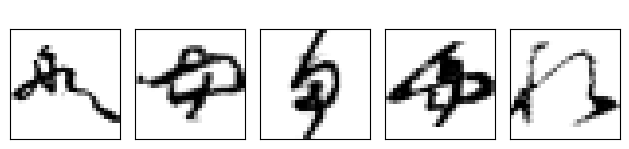

In [10]:
ind=np.random.rand(5) # plotting some examples of the dataset with their labels
plot_input(x,y,ind)

### 
We implement the MLP classifier with the following parameters: 
- max_iter = $200$
- regulatization term $ \alpha = 1 \cdot 10^{-4}$
- solver = 'sgd'
- tol = $1 \cdot 10^{-4}$
- learning_rate_init = $0.1$
- random_state = ID, which ensures the run is the same even if you run it more than once.


In [11]:
# creating the MLP classifier with many possible hidden layer sizes
parameters = {'hidden_layer_sizes': [(10,), (20,), (40,), (20,20,), (40,20,10)]}
MLP=MLPClassifier(activation = 'relu', max_iter = 200, alpha = 1e-4, solver = 'sgd', tol = 1e-4,
                  learning_rate_init = 0.1)
# performing gridsearch to find the optimal hidden layer size
models=GridSearchCV(MLP, parameters, cv=5) 
models.fit(X_training,Y_training)
print("the best model is: ", models.best_estimator_)
print("with score {:.2f}".format(models.best_score_))
print("and best parameters {}".format(models.best_params_))

the best model is:  MLPClassifier(hidden_layer_sizes=(40,), learning_rate_init=0.1, solver='sgd')
with score 0.74
and best parameters {'hidden_layer_sizes': (40,)}


## 1.1 **best model size**

Plot the train and test accuracies as a function of the number of neurons in your neural network. Print also the computation time for the various configuration you try.

Time needed for training size (1,): 0.29 seconds
Time needed for training size (3,): 0.88 seconds
Time needed for training size (5,): 0.54 seconds
Time needed for training size (10,): 0.31 seconds
Time needed for training size (20,): 0.44 seconds
Time needed for training size (40,): 0.59 seconds
Time needed for training size (20, 20): 0.40 seconds
Time needed for training size (30, 30, 20): 0.40 seconds


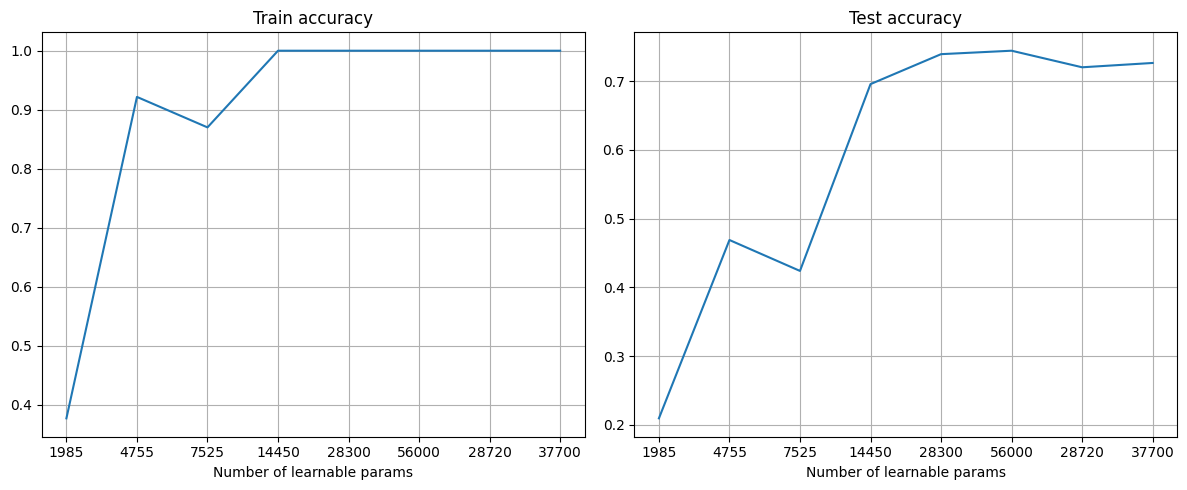

In [12]:
hidden_layer_sizes = [(1,),(3,),(5,),(10,), (20,), (40,), (20,20,),(30,30,20)] # listing all possible hidden layer sizes
hidden_layer_labels = [param_count(size, X_training, Y_training) for size in hidden_layer_sizes]
start_time = time()  # Start time
train_accuracies, test_accuracies = [], []  # initializing the lists for saving train and test accuracies
# for every hidden layer size
for size in hidden_layer_sizes:
    # defining the MLP object with that specific size
    mlp = MLPClassifier(hidden_layer_sizes=size, activation='relu', max_iter=200, alpha=1e-4, 
                        solver='sgd', tol=1e-4, learning_rate_init=0.1)
    mlp.fit(X_training, Y_training) # training the MLP
    current_time = time()
    elapsed_time = current_time - start_time
    start_time = current_time
    print(f"Time needed for training size {size}: {elapsed_time:.2f} seconds") # printing the computation time
    train_accuracies.append(mlp.score(X_training, Y_training)) # saving the accuracies
    test_accuracies.append(mlp.score(X_test, Y_test))
# plotting the train and test accuracies as a function of the number of neurons in your neural network
plot_accuracies([train_accuracies, test_accuracies], [hidden_layer_labels, hidden_layer_labels], ["Train accuracy", "Test accuracy"])

## 1.2 **best learning rate**

the best learning rate value is:  0.2  with score:  0.7523063973063973


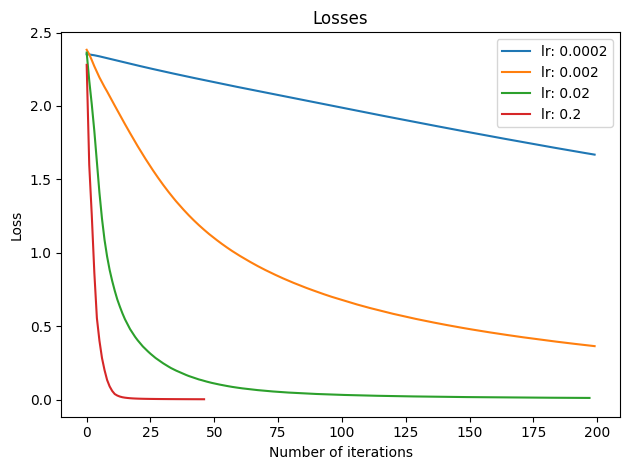

In [13]:
lr_list = [0.0002, 0.002, 0.02, 0.2] # defininf the possible learning rates

# Train the MLPs with the different lerning rates
scores = {}  # dictionary for saving the scores
losses = {}  # dictionary for saving losses

# Get the best hidden layer sizes and batch size from the previous MLPs
hidden_layers=models.best_params_ # keeping the best number of hidden layers found above

# for each learning rate value
for lr in lr_list:
    # defining the MLP object
    mlp = MLPClassifier(hidden_layer_sizes=hidden_layers['hidden_layer_sizes'], activation='relu', max_iter=200, alpha=1e-4, solver='sgd', tol=1e-4,
                        learning_rate_init=lr)
    # training the MLP with this specific learning rate
    mlp.fit(X_training, Y_training)
    scores.update({f'{lr}': mlp.score(X_test, Y_test)}) # saving the scores and losses
    losses.update({f'{lr}': mlp.loss_curve_})
key_best = max(scores, key = scores.get) # finding the best learning rate
print("the best learning rate value is: ", key_best, " with score: ", scores[key_best])
plot_loss(losses)

## 1.3 **testing the best model**

training error:  0.0
test error:  0.25257575757575756


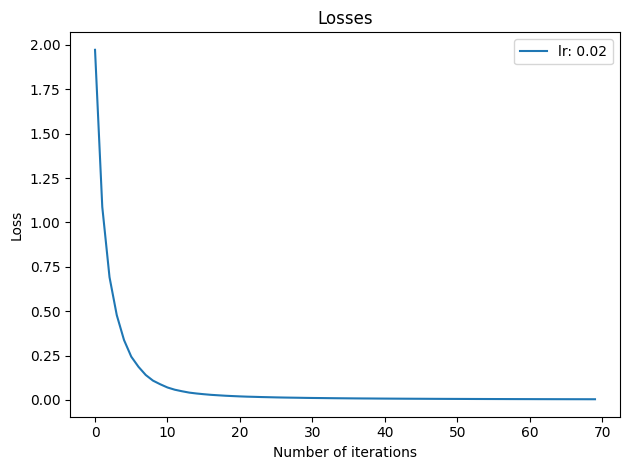

In [14]:
best_hidden_layers = hidden_layers['hidden_layer_sizes'] # defining the best parameters
best_learning_rate = 0.02
# defining the MLP object with the optimal number of hidden parameters and learning rate
mlp = MLPClassifier(hidden_layer_sizes=best_hidden_layers, activation='relu', max_iter=600, alpha=1e-4, solver='sgd', tol=1e-4,
                    batch_size=30, learning_rate_init=best_learning_rate)
mlp.fit(X_training, Y_training) # training
train_error = 1 - mlp.score(X_training, Y_training) # computing the training error
test_error = 1 - mlp.score(X_test, Y_test) # computing the test error
print("training error: ", train_error)
print("test error: ", test_error)
plot_loss({best_learning_rate: mlp.loss_curve_}) # plotting the loss curve

# 2. **MLP implementation from scratch**

In [15]:
class Activation:
    """
    class that implements the activation function and the correspondent derivative
    """

    def __init__(self, name: str) -> None:
        # constructor for the Activation class that sets the activation function (and its derivative)
        # based on the input name (either ReLu or Sigmoid)
        self.name = name # type of activation function 

    def __call__(self, x: np.ndarray) -> np.ndarray:
        # method for computing the activation function in the input point x, which is also returned
        if self.name == 'relu':
            # implementing the ReLU activation function
            u = np.maximum(0, x)
            return u, x
        elif self.name == 'sigmoid':
            # implementing the Sigmoid activation function
            u = 1 / (1 + np.exp(-x))
            return u, x
        else:
            raise ValueError('Activation function not supported')

    def derivative(self, x: np.ndarray) -> np.ndarray:
        # method for computing the derivative of the activation function in the input point x
        if self.name == 'relu':
            # implementing the derivative of the ReLU activation function
            d = np.where(x > 0, 1, 0)
            return d
        elif self.name == 'sigmoid':
            # implementing the derivative of the Sigmoid activation function
            d = np.exp(-x) / (1 + np.exp(-x))**2
            return d
        else:
            raise ValueError('Activation function not supported')

### MLP CLASS

The following block contains the structure of the *MLP* class. You have to complete the `forward` functions. The `forward` function should compute the forward pass of the network.
Note that to be able to perform backpropagation algorithm we have to keep track of all the computation we do in the forward pass. In particular, this is done in the `cache` variable that is stored at each layer. Note that in order to work properly with the already provided `backprop()` method, the cache has to sored in a specific way. In particular we have chosen that the cache is a tuple containing `(a_prev, W, b)` where:
- `a_prev` is the output of the previous layer (np.ndarray)
- `W` is the current weight matrix (np.ndarray)
- `b` is the current bias vector (np.ndarray)

In [16]:
class DiyMlp:
    """
    class that implements the MLP
    keep in mind that all the input are considered with the batch_size as the last dimension.
    """

    def __init__(self, layers: list, learning_rate: float):
        # class constructor method that, given a list of layers and a learning rate, initializes
        # the parameters of the MLP
        # each layer but the last one uses a ReLU activation function, while the last layer
        # uses the sigmoid
        self.n_layers = len(layers)  # number of layers
        params = {}  # dictionary containing the parameters W and b of each layer
        for l in range(1, self.n_layers): # for each layer, we initialize
            # the weight matrix of the layer to a normal distribution rescaled by 0.01
            params[f"W{l}"] = np.random.randn(layers[l], layers[l-1]) * 0.01  
            params[f"b{l}"] = np.zeros((layers[l], 1))  # the bias vector of the layer to zeros
            # the activation function of the layer
            params[f"activation{l}"] = Activation("relu" if l < self.n_layers - 1 else "sigmoid")  
        self.params = params  # saving the parameters and the learning rate
        self.lr = learning_rate

    @staticmethod # does not receive an implicit first argument (self)
    def one_hot(x: np.ndarray, n_classes: int) -> np.ndarray:
        # method that coverts the input vector x into a one-hot encoding, based on
        # the input number of classes
        return np.eye(n_classes)[x.reshape(-1)]

    def forward(self, x: np.ndarray) -> tp.Tuple[np.ndarray, list]:
        # method for implementing the forward propagation of the network
        # for each layer but the last one, it computes the linear transformation and applies
        # the activation function, and only applies the activation function on the last layer
        caches = []  # initializing a list for storing the linear and activation caches
        out = None  # output of the layer
        for l in range(1, self.n_layers): # for each layer of the model except the last
            # storing the input of the layer (the output of the previous layer)
            prev = cp(x) if l == 1 else out
            # computing the linear hypothesis z = W*a_prev + b 
            z = np.dot(self.params[f"W{l}"], prev) + self.params[f"b{l}"]
            # storing the linear cache for backpropagation = (a_prev, W, b)
            linear_cache = (prev, self.params[f"W{l}"], self.params[f"b{l}"])
            # applying the activation function on linear hypothesis
            out, activation_cache = self.params[f"activation{l}"](z)
            # storing both the linear and activation cache
            caches.append((linear_cache, activation_cache))
        return out, caches
    
    @staticmethod
    def cost_function(out: np.ndarray, y: np.ndarray) -> np.ndarray:
        # method for computing and returns the cost/loss function (using the cross-entropy 
        # loss), given the output of the network and the ground truth labels
        return (-1/y.shape[1]) * (np.dot(np.log(out), y.T) + np.dot(np.log(1-out), 1-y.T))

    @staticmethod
    def one_layer_backward(d_pred: np.ndarray, cache: tp.List[tp.Tuple[np.ndarray]], derivative_activation: Activation.derivative) -> tuple:
        # method that computes and returns the derivative of the loss with respect to
        # - the input of the input of the layer d_pred_prev
        # - the weights d_w
        # - the bias d_b
        # after receiving, as input, the derivative of the loss with respect to the output
        # of the layer d_pred and the linear and activation cache
        linear_cache, z = cache  # retrieving the linear and activation cache
        d_z = d_pred * derivative_activation(z) # computing the derivative of the loss with respect to z
        pred_prev, w, _ = linear_cache  # retrieving the input of the layer and the weights from the cache
        m = pred_prev.shape[1]  # retrieving the number of samples
        d_w = (1/m) * np.dot(d_z, pred_prev.T)  # computing the derivative of the loss with respect to w
        d_b = (1/m) * np.sum(d_z, axis=1, keepdims=True)  # computing the derivative of the loss with respect to b
        d_pred_prev = np.dot(w.T, d_z)  # computing the derivative of the loss with respect to the input of the layer
        return d_pred_prev, d_w, d_b
    
    def backprop(self, pred, labels, caches) -> dict:
        # method for computing the backwards pass of the network, given the output of the prediction, 
        # the true labels and the caches, and returns a dictionary containing the derivatives of the
        # loss with respect to the parameters of the network
        grads = {}  # initializing a dictionary for storing the gradients\
        # reshaping the labels to have the same shape as the output of the network
        labels = labels.reshape(pred.shape) 
        caches_len = len(caches)
        # compute the derivative of the loss with respect to the output of the network
        d_pred = -(np.divide(labels, pred) - np.divide(1-labels, 1-pred))  
        current_cache = caches[caches_len - 1]  # retrieving the linear and activation cache of the last layer
        grads[f"d_pred{caches_len - 1}"], grads[f"dW{caches_len}"], grads[f"db{caches_len}"] = self.one_layer_backward(d_pred, current_cache, self.params[f"activation{caches_len}"].derivative)
        # computing the gradient for all the other layers in reverse order
        for l in reversed(range(caches_len - 1)):
            current_cache = caches[l]  # retrieving the linear and activation cache of the layer
            # compute the derivative of the loss with respect to the output of the next layer
            grads[f"d_pred{l}"], grads[f"dW{l + 1}"], grads[f"db{l + 1}"] = self.one_layer_backward(grads[f"d_pred{l + 1}"], current_cache, self.params[f"activation{l + 1}"].derivative)  
        return grads
    
    def update_parameters(self, grads: dict) -> None:
        # method for updatingt the weight matrix and the bias vector using SGD with the input gradients
        for l in range(self.n_layers - 1):
            self.params[f"W{l + 1}"] = self.params[f"W{l + 1}"] - self.lr*grads[f"dW{l + 1}"]
            self.params[f"b{l + 1}"] = self.params[f"b{l + 1}"] - self.lr*grads[f"db{l + 1}"]

    def train(self, x: np.ndarray, y: np.ndarray, epochs: int) -> None:
        # method for training the network, given the input x, the true labels y and the number
        # of epochs:
        x = x.T  # transposing so the batch size matches the first dimension
        # one-hot encoding the labels and transposing so the batch size matches the first dimension
        y = self.one_hot(y, np.unique(y).shape[0]).T  
        cost_history = []  # initializing a list for storing the cost at each epoch
        for _ in range(epochs): # during each epoch
            # computing the output of the network and retrieving the caches
            out, caches = self.forward(x)  
            cost = self.cost_function(out, y)  # computing and saving the cost
            cost_history.append(cost) 
            grads = self.backprop(out, y, caches)  # computing the gradients
            self.update_parameters(grads)  # updating the parameters of the network

    def predict(self, x: np.ndarray) -> np.ndarray:
        # method for computing the output of the network (once trained)
        # for a given input x
        x = x.T # transposing so the batch size matches the first dimension
        out, _ = self.forward(x)  # compute=ing the output of the network
        predictions = np.argmax(out, axis=0)  # getting the predictions with ReLU
        return predictions

### TRAINING

Train the *MLP* you have implemented. Then print its accuracy and plot the confusion matrix to better visualize the performance of the model.

In [17]:
learning_rate = 0.2 # defining the MLP parameters and model
diy_mlp = DiyMlp([784, 40, 10], learning_rate)
diy_mlp.train(X_training, Y_training, 200) # training the model
Y_pred = diy_mlp.predict(X_test) # computing the predictions
# computing the accuracy on the test set and print it
accuracy = 1 - np.sum(Y_pred != Y_test) / len(Y_test)
print("Accuracy on the test set: ", accuracy)

Accuracy on the test set:  0.7523232323232323


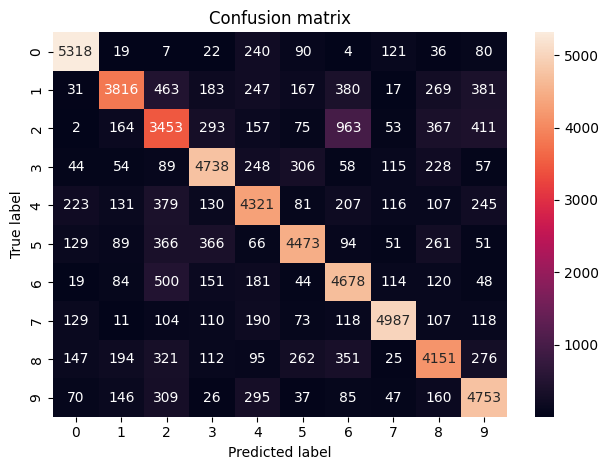

In [18]:
cm=confusion_matrix(Y_test,Y_pred) # computing the confusion matrix
plot_conf_matrix(cm) # plotting the confusion matrix